In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lr.text_processing.util import pre_process_nli_df
from lr.training.util import get_ternary_label
from lr.text_processing.transformations.structural import entailment_internalization
from lr.text_processing.transformations.synonyms import toy_transformation
from lr.stats.h_testing import DGP, get_matched_results, get_paired_t_statistic
from lr.stats.h_testing import get_boot_sample_under_H0,get_boot_p_value
from lr.stats.h_testing import  LIMts_test
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Loading data

In [2]:
train_path = "data/toy/train.csv"
dev_path = "data/toy/dev.csv"
train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
pre_process_nli_df(train)
pre_process_nli_df(dev)

### Training a model using one version of the modified data

In [3]:
max_features = 500
rho = 0.001
label_translation = get_ternary_label
transformation = entailment_internalization 

dgp = DGP(data=train, transformation=transformation, rho=rho)
train_t = dgp.get_sample()

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}
lr = LRWrapper(hyperparams)
lr.fit(train_t)

### Get t statistic for the observable results and matched results

In [4]:
dev_t = transformation(dev)

results = get_matched_results(dev, dev_t, lr, lr.label_translation)
t_obs = get_paired_t_statistic(results)

print(t_obs)

-1.536514528773881


### Get $S$ bootstrap replications under H0

In [5]:
S = 1000
t_boots = []
for _ in range(S):
    boot_sample = get_boot_sample_under_H0(results)
    t = get_paired_t_statistic(boot_sample)
    t_boots.append(t)

t_boots = pd.Series(t_boots)

### Calculating the associated p-value

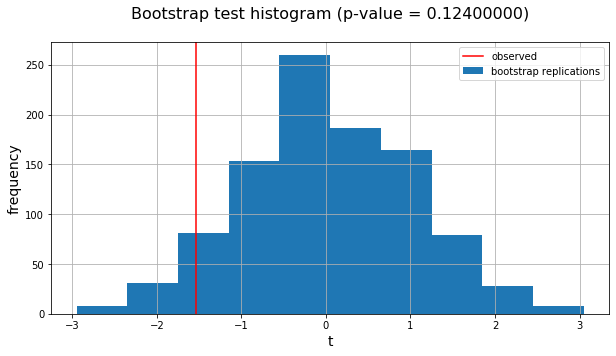

In [6]:
p_value = get_boot_p_value(t_boots, t_obs)

fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label="observed");
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (p-value = {:.8f})".format(p_value) +"\n", fontsize=16)
plt.legend(loc="best");

### Performing multiple tests

**test1: entailment internalization**

In [7]:
M,E,S = 5,1,1000


tests1 = LIMts_test(train=train,
                    dev=dev,
                    transformation=entailment_internalization,
                    rho=0.78,
                    Model=LRWrapper,
                    hyperparams=hyperparams,
                    M=M,
                    E=E,
                    S=S)

tests1

,m,e,observable_t_stats,p_value,time,boot_t_1,boot_t_2,boot_t_3,boot_t_4,boot_t_5,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,1,-7.510676,0.0,2.280654,-2.292273,0.906390,1.091902,-0.447437,-1.046351,...,-0.590281,-0.730297,0.437805,0.785674,-1.046351,0.000000,-1.516196,0.000000,0.577832,-1.183660
1,2,1,-8.056095,0.0,2.326341,-0.137367,-0.662994,0.428768,0.428768,-0.437805,...,-0.140035,1.378997,-1.023727,-1.318761,0.437805,-0.137367,0.447437,-0.701000,-0.730297,0.566139
2,3,1,-7.620008,0.0,2.350477,-0.715199,0.149079,-0.823387,-2.086533,0.156183,...,-0.603572,0.142864,-0.324528,0.294948,-0.633089,0.000000,0.000000,-0.730297,0.132459,-0.160138
3,4,1,-8.056095,0.0,2.950548,-0.929172,0.420269,-1.053361,-0.850060,-0.577832,...,-0.945989,0.000000,0.447437,0.324528,0.555127,-1.650919,0.282899,-0.282899,-0.590281,1.291061
4,5,1,-8.056095,0.0,3.150721,0.850060,1.158569,-0.397517,0.397517,0.137367,...,-1.072113,1.270001,0.000000,-0.152507,-0.500313,0.603572,0.566139,-1.393466,0.913220,-0.301580


### Diferent bootstrap distributions for each experiment

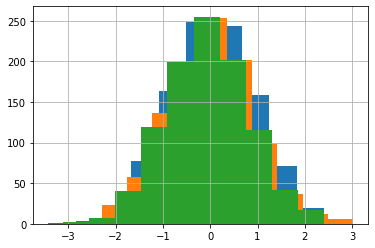

In [8]:
tests1.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

**test2: toy transformation**

In [9]:
tests2 = LIMts_test(train=train,
                   dev=dev,
                   transformation=toy_transformation,
                   rho=0.78,
                   Model=LRWrapper,
                   hyperparams=hyperparams,
                   M=M,
                   E=E,
                   S=S)

tests2

,m,e,observable_t_stats,p_value,time,boot_t_1,boot_t_2,boot_t_3,boot_t_4,boot_t_5,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,1,2.487080,0.004,2.768560,2.145596,-1.347719,0.000000,-0.577832,-1.347719,...,-0.633089,0.817861,1.643990,-1.643990,1.158569,0.000000,0.000000,2.020305,-0.378100,1.137556
1,2,1,0.447437,0.656,2.747800,0.000000,0.000000,0.000000,-0.577832,0.000000,...,0.817861,-0.577832,-1.347719,1.002509,0.000000,0.000000,-0.817861,-1.002509,0.577832,0.447437
2,3,1,-0.577832,0.698,2.839052,-0.577832,1.421338,-0.447437,-0.447437,1.421338,...,NaN,-0.577832,-1.002509,-1.002509,1.421338,0.577832,-0.447437,-1.002509,1.421338,0.577832
3,4,1,-0.707992,0.548,2.690866,-0.333426,-0.534905,0.301580,2.535966,0.833494,...,-0.378100,0.447437,-0.378100,0.000000,-1.270001,1.137556,-1.137556,-1.643990,1.393466,1.421338
4,5,1,0.000000,0.908,2.996548,0.775761,0.534905,-0.277403,1.803339,-1.421338,...,-0.944911,0.896221,0.000000,-0.944911,-1.217161,0.000000,-0.471667,0.471667,-1.710117,-1.508509


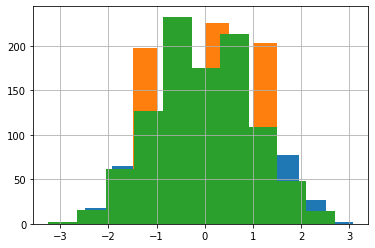

In [10]:
tests2.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

In [11]:
assert np.all(tests1.p_value < (0.05/M*E))
assert not np.all(tests2.p_value < (0.05/M*E))